# 🐘 RFM Analysis using PostgreSQL + Python
This notebook reads the Online Retail dataset, uploads it to PostgreSQL, and performs an RFM analysis using raw SQL.

In [5]:
# 📦 Install required libraries
%pip install pandas sqlalchemy psycopg2-binary

  Using cached sqlalchemy-2.0.41-cp313-cp313-macosx_11_0_arm64.whl.metadata (9.6 kB)
  Using cached psycopg2_binary-2.9.10-cp313-cp313-macosx_14_0_arm64.whl.metadata (4.9 kB)
Using cached sqlalchemy-2.0.41-cp313-cp313-macosx_11_0_arm64.whl (2.1 MB)
Using cached psycopg2_binary-2.9.10-cp313-cp313-macosx_14_0_arm64.whl (3.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [psycopg2-binary]
Note: you may need to restart the kernel to use updated packages.


In [6]:
# 📊 Step 1: Load the dataset
import pandas as pd

# Load dataset
df = pd.read_csv('online_retail.csv', encoding='ISO-8859-1')
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df = df.dropna(subset=['CustomerID'])  # Drop rows with null CustomerID
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [7]:
# 🛠️ Step 2: Connect to PostgreSQL
from sqlalchemy import create_engine

# Using Postgres App default connection
engine = create_engine('postgresql+psycopg2://manavsharma@localhost:5432/manavsharma')
conn = engine.connect()

# Upload to PostgreSQL
df.to_sql('transactions', engine, if_exists='replace', index=False)
print('✅ Data uploaded to PostgreSQL')

✅ Data uploaded to PostgreSQL


In [8]:
# 🧮 Step 3: SQL Query for RFM
query = '''
SELECT 
    "CustomerID" AS customer_id,
    MAX("InvoiceDate") AS last_purchase,
    COUNT(DISTINCT "InvoiceNo") AS frequency,
    SUM("TotalAmount") AS monetary
FROM transactions
GROUP BY "CustomerID"
'''

rfm = pd.read_sql(query, engine)
rfm['last_purchase'] = pd.to_datetime(rfm['last_purchase'])
rfm.head()

,customer_id,last_purchase,frequency,monetary
0,12346.0,2011-01-18 10:17:00,2,0.00
1,12347.0,2011-12-07 15:52:00,7,4310.00
2,12348.0,2011-09-25 13:13:00,4,1797.24
3,12349.0,2011-11-21 09:51:00,1,1757.55
4,12350.0,2011-02-02 16:01:00,1,334.40


In [15]:
# 🧠 Step 4: Compute Recency, Frequency, Monetary Scores

today = rfm['last_purchase'].max() + pd.Timedelta(days=1)
rfm['recency'] = (today - rfm['last_purchase']).dt.days

# Recency Score (reverse scale)
rfm['R_Score'] = pd.qcut(rfm['recency'], q=5, labels=[5, 4, 3, 2, 1])

# Frequency Score
f_qcut, f_bins = pd.qcut(rfm['frequency'], q=5, retbins=True, duplicates='drop')
rfm['F_Score'] = pd.cut(rfm['frequency'], bins=f_bins, labels=range(1, len(f_bins)), include_lowest=True)

# Monetary Score
m_qcut, m_bins = pd.qcut(rfm['monetary'], q=5, retbins=True, duplicates='drop')
rfm['M_Score'] = pd.cut(rfm['monetary'], bins=m_bins, labels=range(1, len(m_bins)), include_lowest=True)

# Combine into RFM Score
rfm['RFM_Score'] = (
    rfm['R_Score'].astype(str) +
    rfm['F_Score'].astype(str) +
    rfm['M_Score'].astype(str)
)


In [16]:
rfm.head()


,customer_id,last_purchase,frequency,monetary,recency,R_Score,F_Score,M_Score,RFM_Score
0,12346.0,2011-01-18 10:17:00,2,0.00,326,1,1,1,111
1,12347.0,2011-12-07 15:52:00,7,4310.00,2,5,3,5,535
2,12348.0,2011-09-25 13:13:00,4,1797.24,75,2,2,4,224
3,12349.0,2011-11-21 09:51:00,1,1757.55,19,4,1,4,414
4,12350.0,2011-02-02 16:01:00,1,334.40,310,1,1,2,112


In [21]:
def assign_segment(score):
    if score == '555':
        return 'Champions'
    elif score[0] == '5' and score[1] in ['4', '5']:
        return 'Loyal Customers'
    elif score[2] == '5':
        return 'Big Spenders'
    elif score[:2] == '11':
        return 'At Risk'
    else:
        return "others"  # skip irrelevant segments


rfm['Segment'] = rfm['RFM_Score'].apply(assign_segment)
rfm.head()

,customer_id,last_purchase,frequency,monetary,recency,R_Score,F_Score,M_Score,RFM_Score,Segment
0,12346.0,2011-01-18 10:17:00,2,0.00,326,1,1,1,111,At Risk
1,12347.0,2011-12-07 15:52:00,7,4310.00,2,5,3,5,535,Big Spenders
2,12348.0,2011-09-25 13:13:00,4,1797.24,75,2,2,4,224,others
3,12349.0,2011-11-21 09:51:00,1,1757.55,19,4,1,4,414,others
4,12350.0,2011-02-02 16:01:00,1,334.40,310,1,1,2,112,At Risk


In [22]:
from sqlalchemy import create_engine

# If you're using Postgres App and username = DB name (likely "manavsharma")
engine = create_engine('postgresql+psycopg2://manavsharma@localhost:5432/manavsharma')

In [23]:
rfm.to_sql('rfm_scores', engine, index=False, if_exists='replace')

372

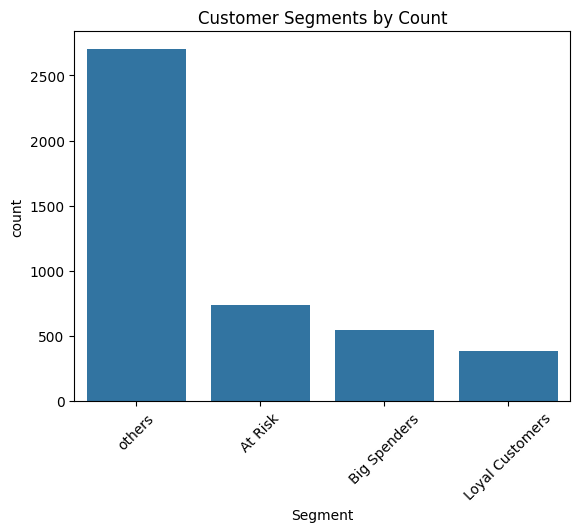

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Customer Segments by Count')
plt.show()
